<a href="https://colab.research.google.com/github/gustavopierre/flight_delay_project/blob/main/notebook/Flight_Delay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![author](https://github.com/gustavopierre/data_science_portfolio/blob/master/author-gustavopierre.png?raw=true)](https://www.linkedin.com/in/gustavo_pierre) [![](https://img.shields.io/badge/python-3.7+-blue.svg)](https://www.python.org/downloads/release/python-365/) [![contributions welcome](https://img.shields.io/badge/contributions-welcome-brightgreen.svg?style=flat)](https://github.com/gustavopierre/data_science_portfolio/issues)

<p align="center">
  <img src="https://github.com/gustavopierre/flight_delay_project/blob/main/images/pexels-matoga-27982027.jpg?raw=true" alt="Avião lvantando vôo no alvorecer" >
  <a href="https://www.pexels.com/pt-br/foto/voo-alvorecer-amanhecer-aurora-27982027/">Foto de Manuel Torres Garcia no Pexels</a>
</p>

# **Predizendo se um Vôo Vai Atrasar ou Não**

## **Resumo**
O Flight Delay Project é um projeto da sprint de Qualidade de Software, Segurança e Sistemas Inteligentes do curso de Pós-graduação em Engenharia de Software da Pontifícia Universidade Católica do Rio de Janeiro. Ele envolve a escolha de um modelo para predizer se um vôo vai ter atraso ou não baseado em dados de aeroportos nos EUA disponibilizados no Kaggle.

## **Introdução**

## **Inicializando o Ambiente**

In [1]:
# config don't show warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# library needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [4]:
# connecting to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

# **Análise Exploratória dos Dados**

In [5]:
# reading the dataset
path = "https://raw.githubusercontent.com/gustavopierre/flight_delay_project/refs/heads/main/api/machinelearning/data/Airlines.csv"

dt = pd.read_csv(path)

In [6]:
# show the five firsts lines
dt.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [7]:
# Checking the types of the data
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


In [9]:
dt.describe()

,id,Flight,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,269692.000000,2427.928630,3.929668,802.728963,132.202007,0.445442
std,155706.604461,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.000000,1.000000,1.000000,10.000000,0.000000,0.000000
25%,134846.500000,712.000000,2.000000,565.000000,81.000000,0.000000
50%,269692.000000,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,404537.500000,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,539383.000000,7814.000000,7.000000,1439.000000,655.000000,1.000000


Flight, Airline, AirportFrom, AirportTo são variáveis categoricas e DayofWeek e Time são variáveis Cíclicas. Ambos os tipos não são adequados para trabalhar em modelos de Machine Learning. O tipo da variável e sua cardinalidade influenciarão na forma que prepararemos as variaveis.

In [10]:
# verificando a cardinalidade
variables = ['Flight', 'Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time']
for var in variables:
    if dt[var].nunique() < 50:
        cardinality = 'low cardinality'
    else:
        cardinality = 'high cardinality'
    print(f"Variável: {var}, Cardinalidade: {cardinality}, Quantidade de valores únicos: {dt[var].nunique()}")

Variável: Flight, Cardinalidade: high cardinality, Quantidade de valores únicos: 6585
Variável: Airline, Cardinalidade: low cardinality, Quantidade de valores únicos: 18
Variável: AirportFrom, Cardinalidade: high cardinality, Quantidade de valores únicos: 293
Variável: AirportTo, Cardinalidade: high cardinality, Quantidade de valores únicos: 293
Variável: DayOfWeek, Cardinalidade: low cardinality, Quantidade de valores únicos: 7
Variável: Time, Cardinalidade: high cardinality, Quantidade de valores únicos: 1131


Analisando e tratando a variável Flight

In [11]:
# Verificando se tem relacao unica entre Flight e 'Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time'
# Agrupar pelas colunas desejadas e contar voos únicos
flight_counts = dt.groupby(
    ['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time']
)['Flight'].nunique().reset_index(name='UniqueFlightsCount')

# Visualizar as primeiras linhas
print(flight_counts.head())

  Airline AirportFrom AirportTo  DayOfWeek  Time  UniqueFlightsCount
0      9E         ABE       DTW          1   360                   2
1      9E         ABE       DTW          1   747                   1
2      9E         ABE       DTW          1   750                   1
3      9E         ABE       DTW          1   981                   1
4      9E         ABE       DTW          1  1000                   1


**Flight** é uma variável que não representa uma quantidade, portanto, não tem ordem nem escala. Não é quantitativa, mas sim qualitativa, possui Cardinalidade Alta (6585 registros únicos) e tem criterios proprios em cada empresa aérea. Não contem um valor único para uma mesma combinação das variáveis 'Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time'.  Será tratada com Frequency Encoding, mais simples e eficiente. Será usada a frequência relativa ao total, pois o valor ja fica entre 0 e 1.

In [12]:
dt["Flight_freq"] = dt['Flight'].map(dt['Flight'].value_counts(normalize=True))
dt[["Flight", "Flight_freq"]].head(10)

,Flight,Flight_freq
0,269,0.000326
1,1558,0.000332
2,2400,0.000161
3,2466,0.000271
4,108,0.000393
5,1094,0.000311
6,1768,0.000224
7,2722,0.000200
8,2606,0.000154
9,2538,0.000187


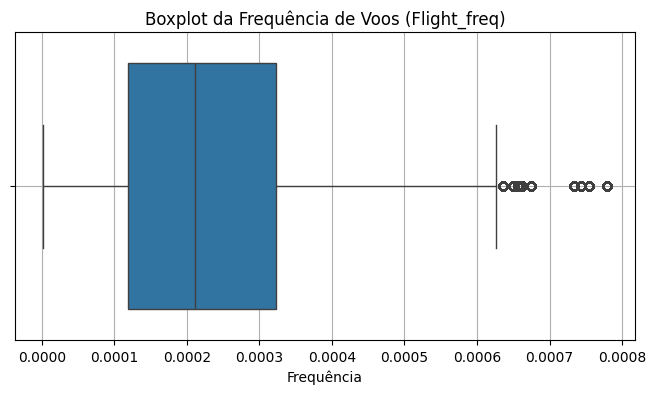

In [13]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=dt['Flight_freq'])
plt.title('Boxplot da Frequência de Voos (Flight_freq)')
plt.xlabel('Frequência')
plt.grid(True)
plt.show()

Analisando e tratando a variável Airline

**Airline** é  uma variável categórica nominal, portanto, qualitativa. Devido a sua baixa cardinalidade, com apenas 18 valores únicos, será processada usando One-Hot Encoding, onde será criada uma coluna para cada Airline, contendo o valor 0 (falso) ou 1 (verdadeiro).

In [14]:
dt_encoded = pd.get_dummies(dt['Airline'], prefix='Airline')
dt = pd.concat([dt, dt_encoded], axis=1)
dt.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Flight_freq,...,Airline_FL,Airline_HA,Airline_MQ,Airline_OH,Airline_OO,Airline_UA,Airline_US,Airline_WN,Airline_XE,Airline_YV
0,1,CO,269,SFO,IAH,3,15,205,1,0.000326,...,False,False,False,False,False,False,False,False,False,False
1,2,US,1558,PHX,CLT,3,15,222,1,0.000332,...,False,False,False,False,False,False,True,False,False,False
2,3,AA,2400,LAX,DFW,3,20,165,1,0.000161,...,False,False,False,False,False,False,False,False,False,False
3,4,AA,2466,SFO,DFW,3,20,195,1,0.000271,...,False,False,False,False,False,False,False,False,False,False
4,5,AS,108,ANC,SEA,3,30,202,0,0.000393,...,False,False,False,False,False,False,False,False,False,False


In [15]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 28 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           539383 non-null  int64  
 1   Airline      539383 non-null  object 
 2   Flight       539383 non-null  int64  
 3   AirportFrom  539383 non-null  object 
 4   AirportTo    539383 non-null  object 
 5   DayOfWeek    539383 non-null  int64  
 6   Time         539383 non-null  int64  
 7   Length       539383 non-null  int64  
 8   Delay        539383 non-null  int64  
 9   Flight_freq  539383 non-null  float64
 10  Airline_9E   539383 non-null  bool   
 11  Airline_AA   539383 non-null  bool   
 12  Airline_AS   539383 non-null  bool   
 13  Airline_B6   539383 non-null  bool   
 14  Airline_CO   539383 non-null  bool   
 15  Airline_DL   539383 non-null  bool   
 16  Airline_EV   539383 non-null  bool   
 17  Airline_F9   539383 non-null  bool   
 18  Airline_FL   539383 non-

Analisando e tratando as variáveis 'AirportFrom' e 'AirportTo'

**AirportFrom** e **AirportTo** são variáveis categóricas nominais de alta cardinalidade, com 293 valores únicos cada uma. Será usado *Frequency Encoding* para tratá-las.

In [16]:
for col in ['AirportFrom', 'AirportTo']:
    freq = dt[col].value_counts(normalize=True)
    dt[col + '_freq'] = dt[col].map(freq)

dt.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Flight_freq,...,Airline_MQ,Airline_OH,Airline_OO,Airline_UA,Airline_US,Airline_WN,Airline_XE,Airline_YV,AirportFrom_freq,AirportTo_freq
0,1,CO,269,SFO,IAH,3,15,205,1,0.000326,...,False,False,False,False,False,False,False,False,0.021851,0.029328
1,2,US,1558,PHX,CLT,3,15,222,1,0.000332,...,False,False,False,False,True,False,False,False,0.028842,0.020638
2,3,AA,2400,LAX,DFW,3,20,165,1,0.000161,...,False,False,False,False,False,False,False,False,0.030882,0.041071
3,4,AA,2466,SFO,DFW,3,20,195,1,0.000271,...,False,False,False,False,False,False,False,False,0.021851,0.041071
4,5,AS,108,ANC,SEA,3,30,202,0,0.000393,...,False,False,False,False,False,False,False,False,0.002423,0.014910


Analisando a variável DayOfWeek.

**DayOfWeek** é uma variável categórica ordinal cíclica. Será tranformada em seno e cosseno.

In [17]:
dt['DayOfWeek_sin'] = np.sin(2 * np.pi * dt['DayOfWeek'] / 7)
dt['DayOfWeek_cos'] = np.cos(2 * np.pi * dt['DayOfWeek'] / 7)
dt.head(10)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Flight_freq,...,Airline_OO,Airline_UA,Airline_US,Airline_WN,Airline_XE,Airline_YV,AirportFrom_freq,AirportTo_freq,DayOfWeek_sin,DayOfWeek_cos
0,1,CO,269,SFO,IAH,3,15,205,1,0.000326,...,False,False,False,False,False,False,0.021851,0.029328,0.433884,-0.900969
1,2,US,1558,PHX,CLT,3,15,222,1,0.000332,...,False,False,True,False,False,False,0.028842,0.020638,0.433884,-0.900969
2,3,AA,2400,LAX,DFW,3,20,165,1,0.000161,...,False,False,False,False,False,False,0.030882,0.041071,0.433884,-0.900969
3,4,AA,2466,SFO,DFW,3,20,195,1,0.000271,...,False,False,False,False,False,False,0.021851,0.041071,0.433884,-0.900969
4,5,AS,108,ANC,SEA,3,30,202,0,0.000393,...,False,False,False,False,False,False,0.002423,0.014910,0.433884,-0.900969
5,6,CO,1094,LAX,IAH,3,30,181,1,0.000311,...,False,False,False,False,False,False,0.030882,0.029328,0.433884,-0.900969
6,7,DL,1768,LAX,MSP,3,30,220,0,0.000224,...,False,False,False,False,False,False,0.030882,0.018875,0.433884,-0.900969
7,8,DL,2722,PHX,DTW,3,30,228,0,0.000200,...,False,False,False,False,False,False,0.028842,0.024372,0.433884,-0.900969
8,9,DL,2606,SFO,MSP,3,35,216,1,0.000154,...,False,False,False,False,False,False,0.021851,0.018875,0.433884,-0.900969
9,10,AA,2538,LAS,ORD,3,40,200,1,0.000187,...,False,False,False,False,False,False,0.022096,0.046110,0.433884,-0.900969


Analisando a variável Time

Time é uma variável categórica contínua cíclica que refere-se ao tempo em minutos a partir de meia-noite. Será tranformada em seno e cosseno.

In [18]:
dt['Time_sin'] = np.sin(2 * np.pi * dt['Time'] / (24 * 60))
dt['Time_cos'] = np.cos(2 * np.pi * dt['Time'] / (24 * 60))

In [19]:
dt.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Flight_freq,...,Airline_US,Airline_WN,Airline_XE,Airline_YV,AirportFrom_freq,AirportTo_freq,DayOfWeek_sin,DayOfWeek_cos,Time_sin,Time_cos
0,1,CO,269,SFO,IAH,3,15,205,1,0.000326,...,False,False,False,False,0.021851,0.029328,0.433884,-0.900969,0.065403,0.997859
1,2,US,1558,PHX,CLT,3,15,222,1,0.000332,...,True,False,False,False,0.028842,0.020638,0.433884,-0.900969,0.065403,0.997859
2,3,AA,2400,LAX,DFW,3,20,165,1,0.000161,...,False,False,False,False,0.030882,0.041071,0.433884,-0.900969,0.087156,0.996195
3,4,AA,2466,SFO,DFW,3,20,195,1,0.000271,...,False,False,False,False,0.021851,0.041071,0.433884,-0.900969,0.087156,0.996195
4,5,AS,108,ANC,SEA,3,30,202,0,0.000393,...,False,False,False,False,0.002423,0.014910,0.433884,-0.900969,0.130526,0.991445


In [20]:
# Seleciona as colunas de Length em diante
# Acha a coluna Length
length_col_index = dt.columns.get_loc('Length')

# Seleciona as colunas Length até o fim
dt_numerical_features = dt.iloc[:, length_col_index:]

# Display the first few rows of the new DataFrame
dt_numerical_features.head()

,Length,Delay,Flight_freq,Airline_9E,Airline_AA,Airline_AS,Airline_B6,Airline_CO,Airline_DL,Airline_EV,...,Airline_US,Airline_WN,Airline_XE,Airline_YV,AirportFrom_freq,AirportTo_freq,DayOfWeek_sin,DayOfWeek_cos,Time_sin,Time_cos
0,205,1,0.000326,False,False,False,False,True,False,False,...,False,False,False,False,0.021851,0.029328,0.433884,-0.900969,0.065403,0.997859
1,222,1,0.000332,False,False,False,False,False,False,False,...,True,False,False,False,0.028842,0.020638,0.433884,-0.900969,0.065403,0.997859
2,165,1,0.000161,False,True,False,False,False,False,False,...,False,False,False,False,0.030882,0.041071,0.433884,-0.900969,0.087156,0.996195
3,195,1,0.000271,False,True,False,False,False,False,False,...,False,False,False,False,0.021851,0.041071,0.433884,-0.900969,0.087156,0.996195
4,202,0,0.000393,False,False,True,False,False,False,False,...,False,False,False,False,0.002423,0.014910,0.433884,-0.900969,0.130526,0.991445


In [21]:
dt_numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Length            539383 non-null  int64  
 1   Delay             539383 non-null  int64  
 2   Flight_freq       539383 non-null  float64
 3   Airline_9E        539383 non-null  bool   
 4   Airline_AA        539383 non-null  bool   
 5   Airline_AS        539383 non-null  bool   
 6   Airline_B6        539383 non-null  bool   
 7   Airline_CO        539383 non-null  bool   
 8   Airline_DL        539383 non-null  bool   
 9   Airline_EV        539383 non-null  bool   
 10  Airline_F9        539383 non-null  bool   
 11  Airline_FL        539383 non-null  bool   
 12  Airline_HA        539383 non-null  bool   
 13  Airline_MQ        539383 non-null  bool   
 14  Airline_OH        539383 non-null  bool   
 15  Airline_OO        539383 non-null  bool   
 16  Airline_UA        53

Como o dataset tem 539383 registros, usaremos somente um subconjunto dele para chegar no modelo de ML. Manteremos a proporcao da coluna target nesta divisao.

In [22]:
seed = 3
# Definindo a variável target
y = dt_numerical_features['Delay']

# Definindo as features (todas as outras colunas)
X = dt_numerical_features.drop('Delay', axis=1)

# Definindo o tamanho do subconjunto (por exemplo, 20%)
subset_size = 0.20

# Realizando a amostragem estratificada
X_subset, _, y_subset, _ = train_test_split(
    X, y,
    test_size=(1-subset_size),  # Usamos 1 - subset_size para obter o tamanho desejado no primeiro output
    random_state=seed,
    stratify=y # Isso garante que as proporções de 'Delay' sejam mantidas
)

# Criando um novo DataFrame com o subconjunto
dt_subset = X_subset.copy()
dt_subset['Delay'] = y_subset

print("Shape do dataset original:", dt_numerical_features.shape)
print("Shape do subconjunto:", dt_subset.shape)

print("\nDistribuição da variável 'Delay' no dataset original:")
display(dt_numerical_features['Delay'].value_counts(normalize=True))

print("\nDistribuição da variável 'Delay' no subconjunto:")
display(dt_subset['Delay'].value_counts(normalize=True))

Shape do dataset original: (539383, 27)
Shape do subconjunto: (107876, 27)

Distribuição da variável 'Delay' no dataset original:


Delay
0    0.554558
1    0.445442
Name: proportion, dtype: float64


Distribuição da variável 'Delay' no subconjunto:


Delay
0    0.554553
1    0.445447
Name: proportion, dtype: float64

In [23]:
test_size = 0.2
seed = 3

# Define y como a coluna 'Delay'
y = dt_subset['Delay']

# Define X como todas as colunas menos 'Delay'
X = dt_subset.drop('Delay', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, shuffle=True, random_state=seed, stratify=y)

scoring = "accuracy"
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((86300, 26), (21576, 26), (86300,), (21576,))

# **Analisando os Modelos**

KNN: 0.6002085747392816 (0.00411308403916061)
CART: 0.5841830822711471 (0.003976128773522249)
NB: 0.5932560834298958 (0.005345285842602673)
SVM: 0.5546234067207415 (0.00010620105897928877)


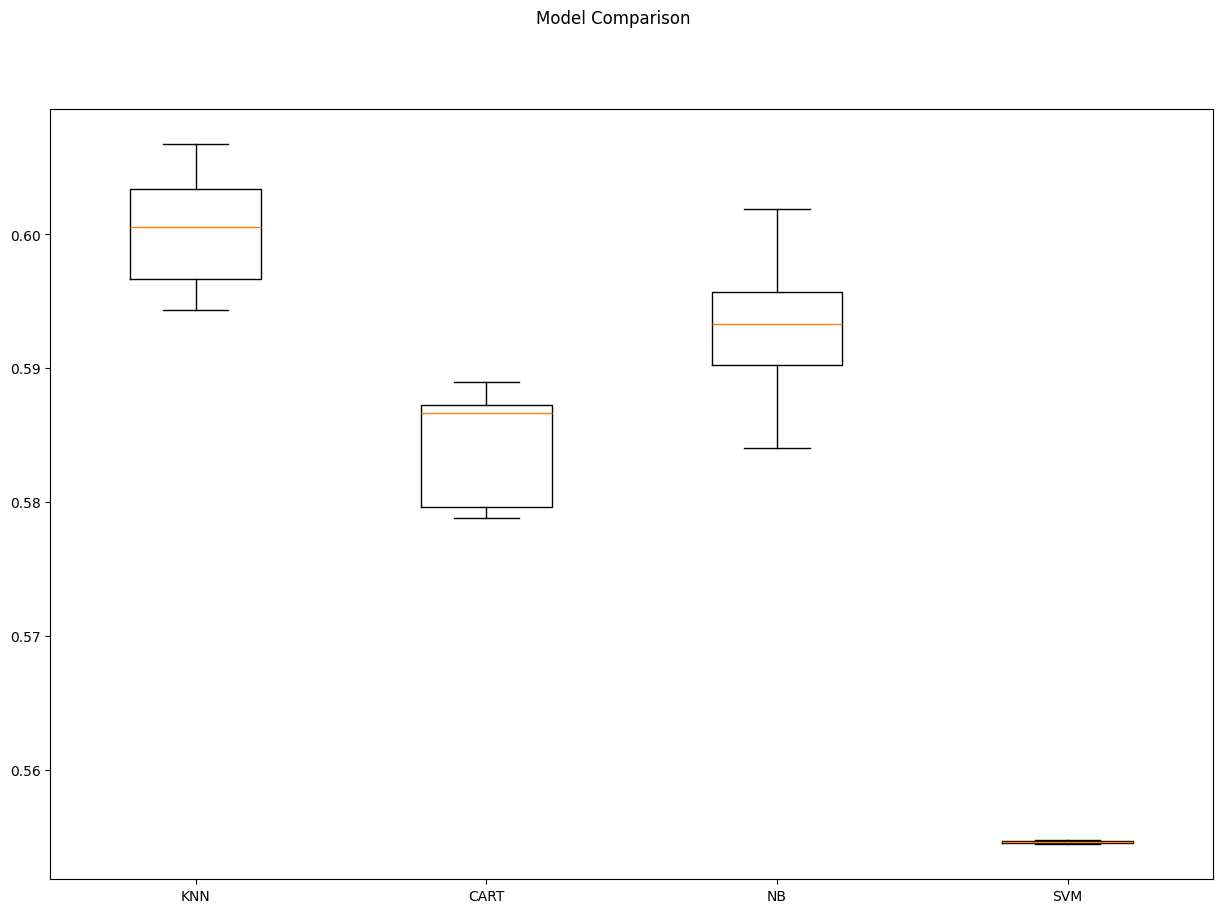

In [24]:
np.random.seed(3)

models = []

models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
models.append(("SVM", SVC()))

results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean()} ({cv_results.std()})"
    print(msg)

fig = plt.figure(figsize=(15,10))
fig.suptitle("Model Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

KNN-orig: 0.6002085747392816 (0.00411308403916061)
CART-orig: 0.5841830822711471 (0.003976128773522249)
NB-orig: 0.5932560834298958 (0.005345285842602673)
SVM-orig: 0.5546234067207415 (0.00010620105897928877)
KNN-std: 0.6081228273464658 (0.004916822848624022)
CART-std: 0.5838702201622248 (0.00412514484356894)
NB-std: 0.5934067207415992 (0.005001835802779174)
SVM-std: 0.6436964078794901 (0.005053379354984556)
KNN-norm: 0.6106604866743917 (0.005420664860945109)
CART-norm: 0.5821436848203939 (0.004613347481987505)
NB-norm: 0.5934067207415992 (0.005001835802779174)
SVM-norm: 0.6422711471610661 (0.00514171086234748)


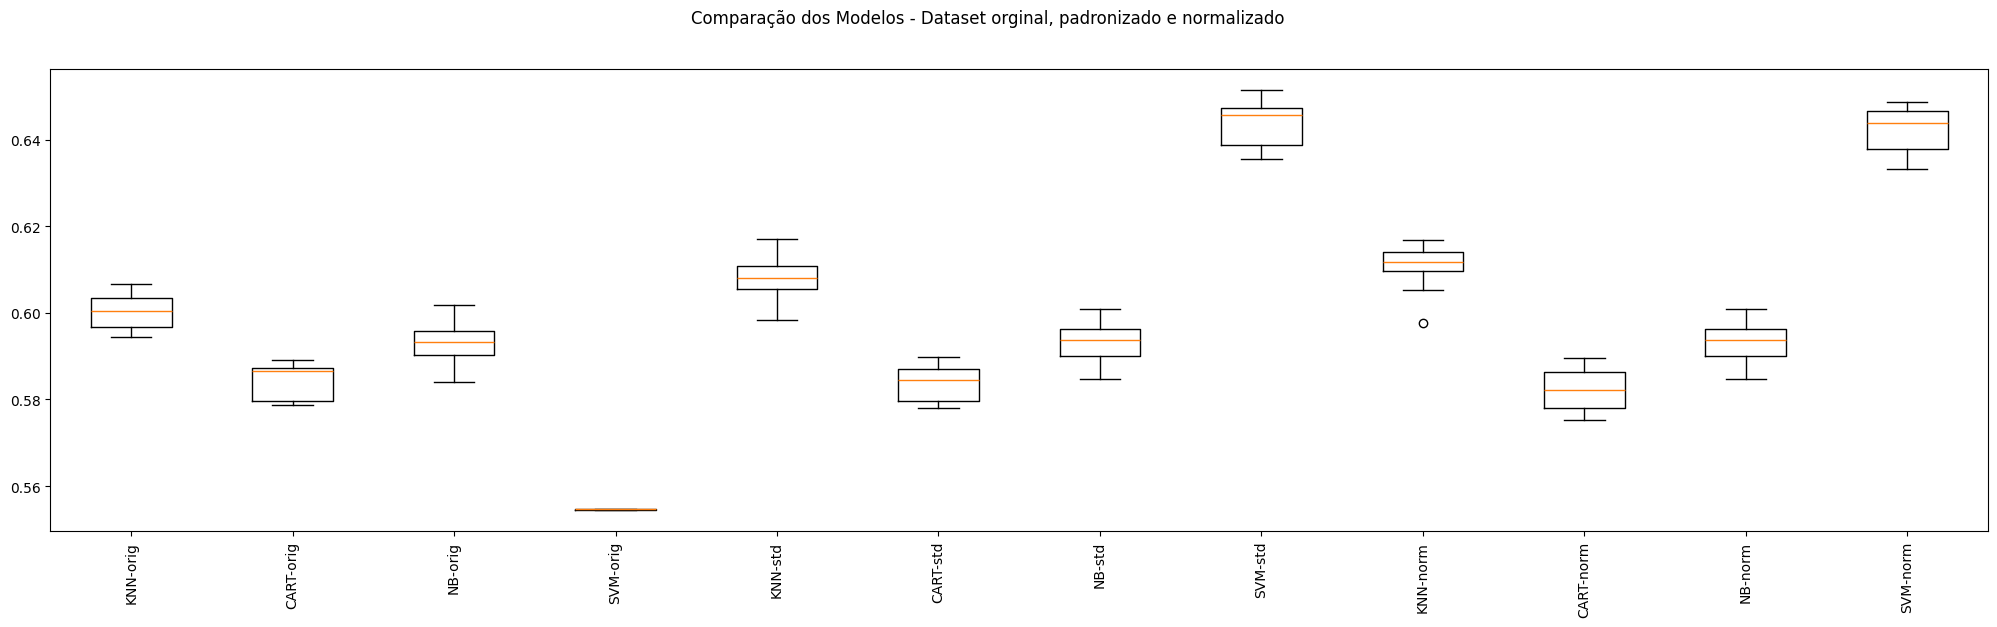

In [27]:
np.random.seed(3)

pipelines = []
results = []
names = []

knn = ("KNN", KNeighborsClassifier())
cart = ("CART", DecisionTreeClassifier())
naive_bayes = ("NB", GaussianNB())
svm = ("SVM", SVC())

standard_scaler = ("StandardScaler", StandardScaler())
min_max_scaler = ("MinMaxScaler", MinMaxScaler())

# dataset original
pipelines.append(("KNN-orig", Pipeline([knn])))
pipelines.append(("CART-orig", Pipeline([cart])))
pipelines.append(("NB-orig", Pipeline([naive_bayes])))
pipelines.append(("SVM-orig", Pipeline([svm])))

# dataset padronizado
pipelines.append(("KNN-std", Pipeline([standard_scaler, knn])))
pipelines.append(("CART-std", Pipeline([standard_scaler, cart])))
pipelines.append(("NB-std", Pipeline([standard_scaler, naive_bayes])))
pipelines.append(("SVM-std", Pipeline([standard_scaler, svm])))

# dataset normalizado
pipelines.append(("KNN-norm", Pipeline([min_max_scaler, knn])))
pipelines.append(("CART-norm", Pipeline([min_max_scaler, cart])))
pipelines.append(("NB-norm", Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(("SVM-norm", Pipeline([min_max_scaler, svm])))

# executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean()} ({cv_results.std()})"
    print(msg)

# boxplot de comparação dos modelos
fig = plt.figure(figsize=(25, 6))
fig.suptitle("Comparação dos Modelos - Dataset orginal, padronizado e normalizado")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

In [28]:
# Tuning do KNN
np.random.seed(3)

pipelines = []

knn = ("KNN", KNeighborsClassifier())
standard_scaler = ("StandardScaler", StandardScaler())
min_max_scaler = ("MinMaxScaler", MinMaxScaler())

pipelines.append(("KNN-orig", Pipeline([knn])))
pipelines.append(("KNN-std", Pipeline(steps=[standard_scaler, knn])))
pipelines.append(("KNN-norm", Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,6,9,11,13,15,17,19,21],
    'KNN__metric': ['euclidean', 'manhattan', 'minkowski'],
}

for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    print(f"Sem tratamento de missings: {name} - Melhor acurácia: {grid.best_score_} - Melhor parâmetro: {grid.best_params_}")

Sem tratamento de missings: KNN-orig - Melhor acurácia: 0.6241135573580532 - Melhor parâmetro: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 19}
Sem tratamento de missings: KNN-std - Melhor acurácia: 0.640127462340672 - Melhor parâmetro: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 21}
Sem tratamento de missings: KNN-norm - Melhor acurácia: 0.6365932792584009 - Melhor parâmetro: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 21}


In [ ]:
# Tuning do SVM
np.random.seed(3)

pipelines = []

svm = ("SVM", SVC())
standard_scaler = ("StandardScaler", StandardScaler())
min_max_scaler = ("MinMaxScaler", MinMaxScaler())

pipelines.append(("SVM-orig", Pipeline([svm])))
pipelines.append(("SVM-std", Pipeline(steps=[standard_scaler, svm])))
pipelines.append(("SVM-norm", Pipeline(steps=[min_max_scaler, svm])))

param_grid = {
    'SVM__C': [0.1, 1, 10, 100],
    'SVM__kernel': ['linear', 'rbf', 'poly'],
    'SVM__gamma': ['scale', 'auto']  # Só é usado para alguns kernels
}

for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    print(f"Sem tratamento de missings: {name} - Melhor acurácia: {grid.best_score_} - Melhor parâmetro: {grid.best_params_}")


In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='manhattan', n_neighbors=21)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

In [ ]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

# **Preparando o Pipeline**

Nas fases anteriores, fizemos uma Análise Exploratória dos Dados (AED) e chegamos a um modelo com melhor acurácia. Agora vamos criar o pipeline para gerar o arquivo que usarmos no sistema que será desenvolvido. Partiremos do início, lendo o dataset e reduzindo-o. O processamento das variávies será realizado utilizando o recursos da biblioteca scikit-learn.

In [ ]:
# carregando o dataset novamente
path = "/content/drive/MyDrive/Colab Notebooks/Airlines.csv"

dt = pd.read_csv(path)

Vamos reduzir o dataset para 20% do original devido ao tempo de processamento, como já mostrado na AED.

In [ ]:
seed = 3
# Definindo a variável target
y = dt['Delay']

# Definindo as features (todas as outras colunas)
X = dt.drop('Delay', axis=1)

# Definindo o tamanho do subconjunto (por exemplo, 20%)
subset_size = 0.20

# Realizando a amostragem estratificada
X_subset, _, y_subset, _ = train_test_split(
    X, y,
    test_size=(1-subset_size),  # Usamos 1 - subset_size para obter o tamanho desejado no primeiro output
    random_state=seed,
    stratify=y # Isso garante que as proporções de 'Delay' sejam mantidas
)

# Criando um novo DataFrame com o subconjunto
dt_subset = X_subset.copy()
dt_subset['Delay'] = y_subset

print("Shape do dataset original:", dt_numerical_features.shape)
print("Shape do subconjunto:", dt_subset.shape)

print("\nDistribuição da variável 'Delay' no dataset original:")
display(dt_numerical_features['Delay'].value_counts(normalize=True))

print("\nDistribuição da variável 'Delay' no subconjunto:")
display(dt_subset['Delay'].value_counts(normalize=True))

Shape do dataset original: (539383, 27)
Shape do subconjunto: (107876, 9)

Distribuição da variável 'Delay' no dataset original:


,proportion
Delay,
0,0.554558
1,0.445442



Distribuição da variável 'Delay' no subconjunto:


,proportion
Delay,
0,0.554553
1,0.445447


In [ ]:
dt_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107876 entries, 330391 to 177903
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           107876 non-null  int64 
 1   Airline      107876 non-null  object
 2   Flight       107876 non-null  int64 
 3   AirportFrom  107876 non-null  object
 4   AirportTo    107876 non-null  object
 5   DayOfWeek    107876 non-null  int64 
 6   Time         107876 non-null  int64 
 7   Length       107876 non-null  int64 
 8   Delay        107876 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 8.2+ MB


Para criar um pipeline que trata diferentes tipos de variáveis de forma adequada, utilizaremos o `ColumnTransformer` do scikit-learn. Este transformador permite aplicar diferentes transformações a diferentes subconjuntos de colunas.

As transformações serão as seguintes:
- **Variáveis de Alta Cardinalidade e Nominal**: 'Flight', 'AirportFrom', 'AirportTo' serão tratadas com Frequency Encoding.
- **Variável de Baixa Cardinalidade e Nominal**: 'Airline' será tratada com One-Hot Encoding.
- **Variáveis Cíclicas**: 'DayOfWeek' e 'Time' serão transformadas em suas componentes seno e cosseno.
- **Variável Numérica Contínua**: 'Length' será padronizada usando `StandardScaler`.

As variáveis transformadas (freq encoding, one-hot encoding, seno/cosseno) também precisarão ser padronizadas, o que será feito após o `ColumnTransformer` com outro `StandardScaler`.

Finalmente, o modelo `KNeighborsClassifier` com os melhores parâmetros encontrados (`n_neighbors=21`, `metric='manhattan'`) será aplicado.

In [ ]:
# Define as colunas para cada tipo de transformação
high_cardinality_cols = ['Flight', 'AirportFrom', 'AirportTo']
low_cardinality_cols = ['Airline']
cyclic_cols = ['DayOfWeek', 'Time']
numerical_cols = ['Length']
target_col = 'Delay'

# Cria os transformadores personalizados
def frequency_encoding(X):
    X_copy = X.copy()
    for col in high_cardinality_cols:
        freq = X_copy[col].value_counts(normalize=True)
        X_copy[col] = X_copy[col].map(freq)
    return X_copy[high_cardinality_cols] # Retorna apenas as colunas transformadas

def cyclic_transformer(X):
    X_copy = X.copy()
    for col in cyclic_cols:
        if col == 'DayOfWeek':
            X_copy[col + '_sin'] = np.sin(2 * np.pi * X_copy[col] / 7)
            X_copy[col + '_cos'] = np.cos(2 * np.pi * X_copy[col] / 7)
        elif col == 'Time':
            X_copy[col + '_sin'] = np.sin(2 * np.pi * X_copy[col] / (24 * 60))
            X_copy[col + '_cos'] = np.cos(2 * np.pi * X_copy[col] / (24 * 60))
    return X_copy[[col + '_sin' for col in cyclic_cols] + [col + '_cos' for col in cyclic_cols]] # Retorna apenas as colunas transformadas


# Cria os pipelines para cada tipo de feature
preprocessor = ColumnTransformer(
    transformers=[
        ('freq', FunctionTransformer(func=frequency_encoding), high_cardinality_cols),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), low_cardinality_cols),
        ('cyclic', FunctionTransformer(func=cyclic_transformer), cyclic_cols),
        ('scaler_num', StandardScaler(), numerical_cols) # Padroniza 'Length'
    ],
    remainder='passthrough' # Mantém as outras colunas (neste caso, 'id' e 'Delay' - que serão removidas antes de passar para o pipeline)
)

# Cria o pipeline completo
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()), # Padroniza todas as features após o preprocessor
    ('knn', KNeighborsClassifier(n_neighbors=21, metric='manhattan'))
])

# Separa as features (X) e o target (y) do subset
X_subset_for_pipeline = dt_subset.drop(target_col, axis=1)
y_subset_for_pipeline = dt_subset[target_col]

# Remove a coluna 'id'
X_subset_for_pipeline = X_subset_for_pipeline.drop(['id'], axis=1)


# Divide o subconjunto em treino e teste para o pipeline
X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(
    X_subset_for_pipeline, y_subset_for_pipeline,
    test_size=test_size,
    shuffle=True,
    random_state=seed,
    stratify=y_subset_for_pipeline
)

# Treina o pipeline
model_pipeline.fit(X_train_pipe, y_train_pipe)

# Avalia o pipeline no conjunto de teste
accuracy = model_pipeline.score(X_test_pipe, y_test_pipe)
print(f"Acurácia do pipeline no conjunto de teste: {accuracy}")

Acurácia do pipeline no conjunto de teste: 0.6386262513904338


O pipeline foi criado e treinado com sucesso! Agora ele pode ser usado para fazer predições em novos dados, garantindo que as mesmas transformações aplicadas aos dados de treinamento sejam aplicadas aos novos dados.

Para demonstrar como usar o pipeline para fazer predições em novos dados, vou criar um pequeno exemplo de dados de teste.

In [ ]:
# Exemplo de novos dados para predição
new_data = pd.DataFrame({
    'Airline': ['CO', 'US', 'AA'],
    'Flight': [269, 1558, 2400],
    'AirportFrom': ['SFO', 'PHX', 'LAX'],
    'AirportTo': ['IAH', 'CLT', 'DFW'],
    'DayOfWeek': [3, 3, 3],
    'Time': [15, 15, 20],
    'Length': [205, 222, 165],
    'id': [1, 2, 3] # 'id' will be dropped by the pipeline
})

# Remove a coluna 'id' antes de passar para o pipeline para predição
new_data_for_prediction = new_data.drop('id', axis=1)

# Faz a predição usando o pipeline treinado
predictions_pipeline = model_pipeline.predict(new_data_for_prediction)

print("\nPredições para os novos dados:")
print(predictions_pipeline)


Predições para os novos dados:
[1 0 1]


In [ ]:
import pickle

# Salva o pipeline treinado em um arquivo
filename = 'finalized_model_pipeline.pkl'
pickle.dump(model_pipeline, open(filename, 'wb'))

print(f"Pipeline salvo em '{filename}'")

Pipeline salvo em 'finalized_model_pipeline.pkl'


In [ ]:
import pickle
import pandas as pd

# Carrega o pipeline do arquivo
filename = 'finalized_model_pipeline.pkl'
loaded_pipeline = pickle.load(open(filename, 'rb'))

# Exemplo de novos dados para predição (certifique-se de que as colunas estejam na mesma ordem que os dados de treino, exceto 'id')
new_data_to_predict = pd.DataFrame({
    'Airline': ['CO', 'US', 'AA'],
    'Flight': [269, 1558, 2400],
    'AirportFrom': ['SFO', 'PHX', 'LAX'],
    'AirportTo': ['IAH', 'CLT', 'DFW'],
    'DayOfWeek': [3, 3, 3],
    'Time': [15, 15, 20],
    'Length': [205, 222, 165],
    # 'id': [1, 2, 3] # 'id' will be dropped by the pipeline
})

# Remove a coluna 'id' antes de passar para o pipeline para predição
# new_data_to_predict = new_data_to_predict.drop('id', axis=1)


# Faz a predição usando o pipeline carregado
predictions_loaded_pipeline = loaded_pipeline.predict(new_data_to_predict)

print("Predições usando o pipeline carregado:")
print(predictions_loaded_pipeline)

Predições usando o pipeline carregado:
[1 0 1]
